```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - Performance Comparison Method

## Contents

- [Model Performance Comparison Method Description](#base)
- [Load daily data and model](#data_d)
- [Model Performance Comparison Method](#method)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd 
import numpy as np

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
from model import (
    get_pm25_data_for_modelling,
    split_df_for_ts_modelling_offset
)

from measure import (
    get_rmse,
    walk_forward_ts_model_validation,
    get_mean_folds_rmse_for_n_prediction_points,
    prepare_data_for_visualization
)

from plot import (
    visualize_results
)

---
<a id='base'></a>

## Model Performance Comparison Method Description

XXXXXX - text in the Final notebook

---
<a id='data_d'></a>

## Load daily data and model

In [7]:
dfd = get_pm25_data_for_modelling('ts', 'd')
dfd.head()

common.py | 42 | get_pm25_data_for_modelling | 08-Jun-20 22:24:14 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-pollution/agh/data/dfpm25_2008-2018_daily.hdf
common.py | 43 | get_pm25_data_for_modelling | 08-Jun-20 22:24:14 | INFO: Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


In [8]:
model_name = 'AR'

In [9]:
df = dfd.copy()

In [11]:
# Define first past/future cutoff point in time offset (1 year of data)
#cut_off_offset = 365*24 # for hourly data
cut_off_offset = 365 # for daily data

# Predict for X points
#n_pred_points = 24 # for hourly data
n_pred_points = 7 # for daily data

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#period = 'H' # for hourly data
period = 'D' # for daily data

### Train test split

In [14]:
# Create train / test datasets (with the offset of cut_off_offset datapoints from the end)
df_train, df_test = split_df_for_ts_modelling_offset(data=df, cut_off_offset=cut_off_offset, period=period)

common.py | 159 | split_df_for_ts_modelling_offset | 08-Jun-20 22:35:37 | INFO: Observations: 4019
common.py | 160 | split_df_for_ts_modelling_offset | 08-Jun-20 22:35:37 | INFO: Training Observations: 3653
common.py | 161 | split_df_for_ts_modelling_offset | 08-Jun-20 22:35:37 | INFO: Testing Observations: 365
common.py | 163 | split_df_for_ts_modelling_offset | 08-Jun-20 22:35:37 | INFO: (4019, 1), (3653, 1), (365, 1), 4018


In [15]:
df_train.shape

(3653, 1)

In [16]:
df_test.shape

(365, 1)

### Train the model

In [17]:
# Train the model / the model proposes the ideal number of lags for forecasting
model = AR(df_train)
model_fitted = model.fit()

In the above, we are simply creating a testing and training dataset and then creating and fitting our AR() model. The AR() function tries to estimate the number of lags for the prediction. Once you’ve fit the model, you can look at the chosen lag and parameters of the model using some simple print statements.

In [18]:
model_fitted

In [19]:
print(f'The lag value chose is: {model_fitted.k_ar}')

The lag value chose is: 30


In [20]:
print(f'The coefficients of the model are:\n {model_fitted.params}')

The coefficients of the model are:
 const       3.254686
L1.pm25     0.702070
L2.pm25    -0.144036
L3.pm25     0.078781
L4.pm25    -0.012828
L5.pm25     0.002850
L6.pm25     0.018810
L7.pm25     0.026406
L8.pm25     0.040924
L9.pm25     0.008997
L10.pm25   -0.038482
L11.pm25    0.040293
L12.pm25    0.076362
L13.pm25   -0.011441
L14.pm25    0.049392
L15.pm25   -0.055448
L16.pm25    0.066617
L17.pm25   -0.002334
L18.pm25   -0.003607
L19.pm25    0.056132
L20.pm25   -0.013051
L21.pm25    0.066457
L22.pm25   -0.004800
L23.pm25    0.003229
L24.pm25   -0.039893
L25.pm25    0.012186
L26.pm25    0.016868
L27.pm25   -0.036194
L28.pm25    0.018096
L29.pm25   -0.022881
L30.pm25    0.014114
dtype: float64


---
<a id='method'></a>

## Model Performance Comparison Method

In [ ]:
# Testing
fold_results = walk_forward_ts_model_validation(data=df, 
                                         col_name='pm25', 
                                         model_params=[3.254686, 0.702070, -0.144036], 
                                         cut_off_offset=cut_off_offset, 
                                         n_pred_points=n_pred_points, 
                                         n_folds=1)

In [ ]:
len(fold_results)

In [ ]:
fold_results[0]

In [22]:
# One point forecast - part 1

# See Train the model section above

In [23]:
type(model_fitted.params)

pandas.core.series.Series

In [24]:
%%time
# One point forecast - part 2


# Validate result on test
# Creates 365*24*24 models for hourly data, or 365*7 models for hourly data
fold_results = walk_forward_ts_model_validation(data=df, 
                                         col_name='pm25', 
                                         model_params=model_fitted.params[:], 
                                         cut_off_offset=cut_off_offset, 
                                         n_pred_points=n_pred_points, 
                                         n_folds=-1)
print(len(fold_results))
print(fold_results[0])

365
             observed  predicted      error  abs_error
Datetime                                              
2018-01-02  67.991848  49.379772  18.612076  18.612076
2018-01-03  16.026950  46.310684  30.283734  30.283734
2018-01-04  14.590020  42.722729  28.132708  28.132708
2018-01-05  22.094854  36.818753  14.723899  14.723899
2018-01-06  62.504217  39.552410  22.951806  22.951806
2018-01-07  43.929804  44.885109   0.955304   0.955304
2018-01-08  22.088192  47.602331  25.514139  25.514139
CPU times: user 8.1 s, sys: 49 ms, total: 8.14 s
Wall time: 8.17 s


In [25]:
fold_results[359][:1]

,observed,predicted,error,abs_error
Datetime,,,,
2018-12-26,NaN,17.102352,NaN,NaN


---
<a id='metric'></a>

## The metric

In [ ]:
# Calculate RMSE for each fold

show_n_points_of_forecast = 1

start_index = show_n_points_of_forecast - 1
end_index = show_n_points_of_forecast

rmse_for_folds = []

i = 0

# n_pred_points results from the end contain NaNs
for fold in fold_results[:len(fold_results)-n_pred_points]:
    
    i += 1
    
    rmse = get_rmse(observed=fold[start_index:end_index]['observed'], 
                    predicted=fold[start_index:end_index]['predicted'])
    rmse_for_folds.append(rmse)
    #print(f'{i:03} = {model_name} RMSE {rmse}')
    

# Calculate Mean RMSE for show_n_points_of_forecast

pd.Series(rmse_for_folds).mean()

In [26]:
%%time
# Returns a list of mean folds RMSE for n_pred_points (starting at 1 point forecast)
res = get_mean_folds_rmse_for_n_prediction_points(fold_results=fold_results, n_pred_points=n_pred_points)
res

CPU times: user 2.4 s, sys: 10.8 ms, total: 2.41 s
Wall time: 2.42 s


[9.407572067039105,
 12.302882402234635,
 12.889160614525139,
 13.248969832402235,
 13.538120949720671,
 13.71186312849162,
 13.83969469273743]

### Build resulting table

In [27]:
index = np.arange(1, n_pred_points+1)
final_comparison_results = pd.DataFrame(data=res, columns=['AR'], index=index)

# Add another results
res2 = pd.DataFrame(data=res, columns=['AR2'], index=index)
res3 = pd.DataFrame(data=res, columns=['AR3'], index=index)

cols = [final_comparison_results, res2, res3]

# Combine everything
final_comparison_results = pd.concat(cols, axis=1)

# Index / rows -> n_pred_points
# Columns
final_comparison_results

,AR,AR2,AR3
1,9.407572,9.407572,9.407572
2,12.302882,12.302882,12.302882
3,12.889161,12.889161,12.889161
4,13.248970,13.248970,13.248970
5,13.538121,13.538121,13.538121
6,13.711863,13.711863,13.711863
7,13.839695,13.839695,13.839695


In [28]:
# Transpose for better visibility
# Columns -> n_pred_points for easch fold
# Rows -> algorithms
final_comparison_results.T

# pokolorowac tabelke (min/max)

,1,2,3,4,5,6,7
AR,9.407572,12.302882,12.889161,13.24897,13.538121,13.711863,13.839695
AR2,9.407572,12.302882,12.889161,13.24897,13.538121,13.711863,13.839695
AR3,9.407572,12.302882,12.889161,13.24897,13.538121,13.711863,13.839695


---
<a id='visual'></a>

## Visual representation

In [36]:
# One point forecast - part 3

# Show forecasts for n-th point in the future
#show_n_points_of_forecasts = [1, 12, 24] # for hourly data
show_n_points_of_forecasts = [1, 3, 7] # for daily data

# Used to zoom the plots (date ranges shown in the plots)
start_end_dates = [
    ('2018-01-01', '2019-01-01'), 
    ('2018-02-01', '2018-04-01'), 
    ('2018-11-01', '2019-01-01')
]

# Type of plot
# 0 -> plot_observed_vs_predicted
# 1 -> plot_observed_vs_predicted_with_error
plot_types = [0, 1, 1]

# File names for plots (format png will be used, do not add .png extension)
#base_file_path = f'images/TEST_REMOVE_pm25_obs_vs_pred_365_h_ts_{model_name}' # for hourly data
base_file_path = f'images/TEST_REMOVE_pm25_obs_vs_pred_365_d_ts_{model_name}' # for daily data

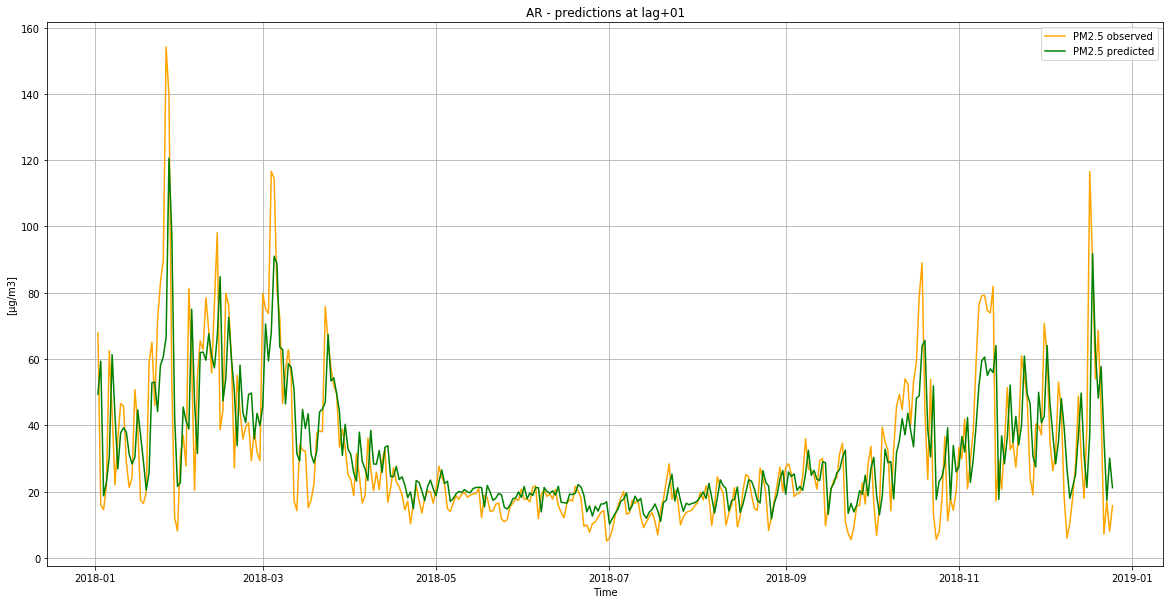

results.py | 83 | visualize_results | 09-Jun-20 00:08:30 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_01_lag-01.png


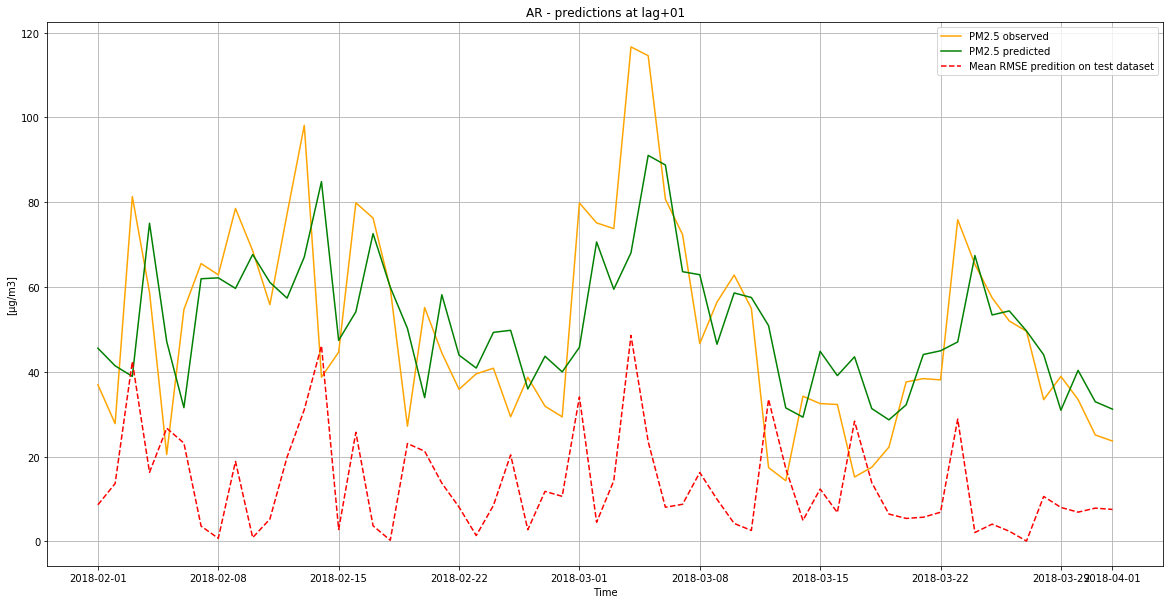

results.py | 83 | visualize_results | 09-Jun-20 00:08:31 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_01_lag-03.png


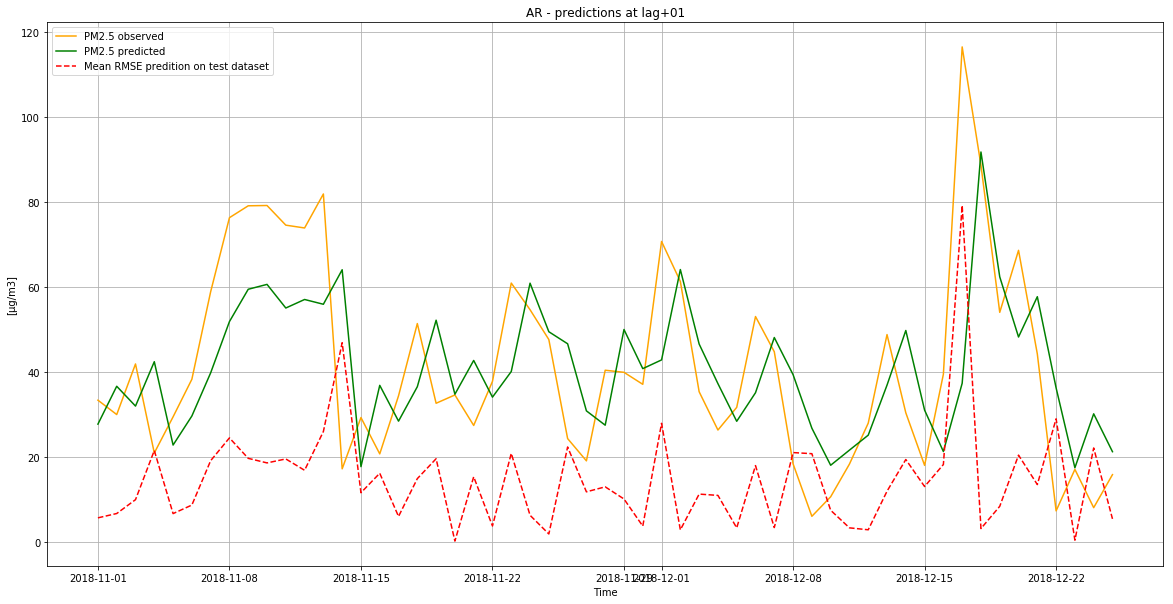

results.py | 83 | visualize_results | 09-Jun-20 00:08:31 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_01_lag-07.png


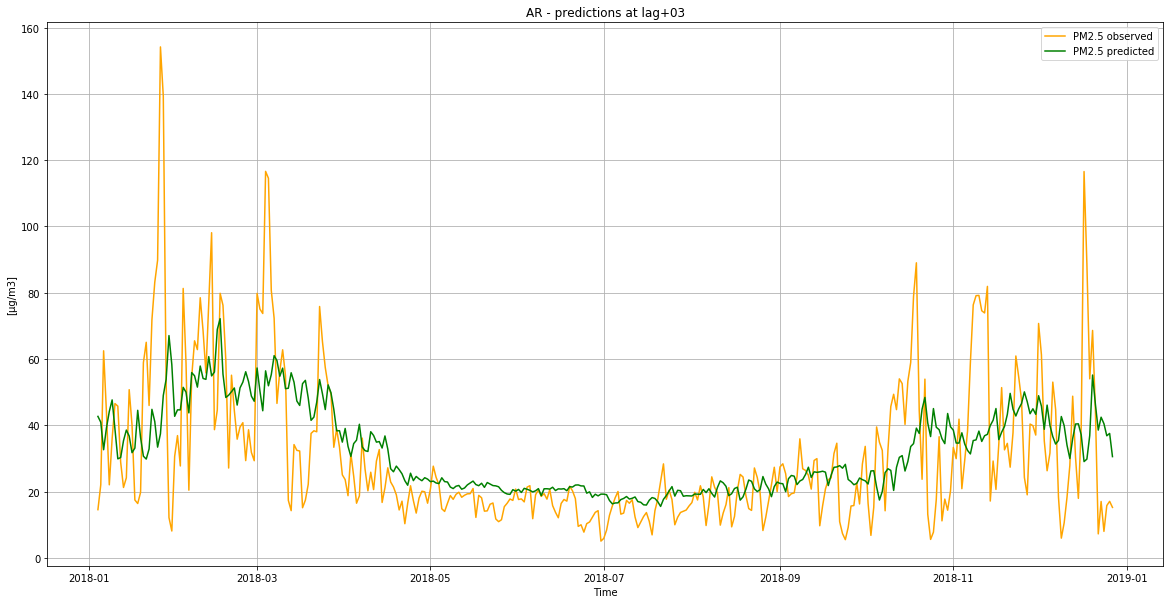

results.py | 83 | visualize_results | 09-Jun-20 00:08:32 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_02_lag-01.png


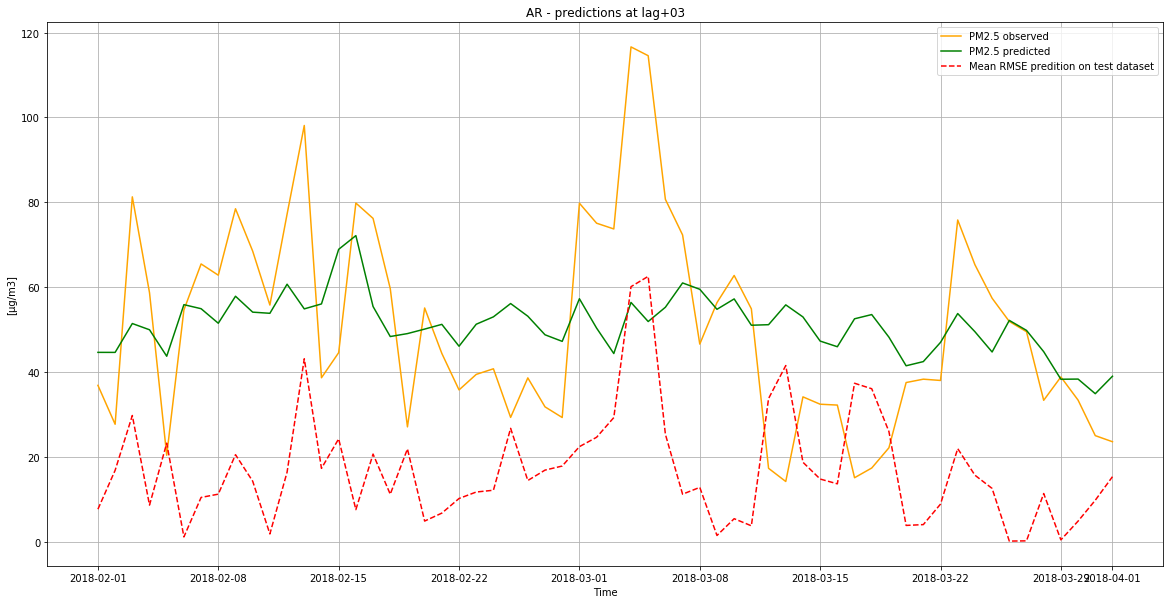

results.py | 83 | visualize_results | 09-Jun-20 00:08:33 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_02_lag-03.png


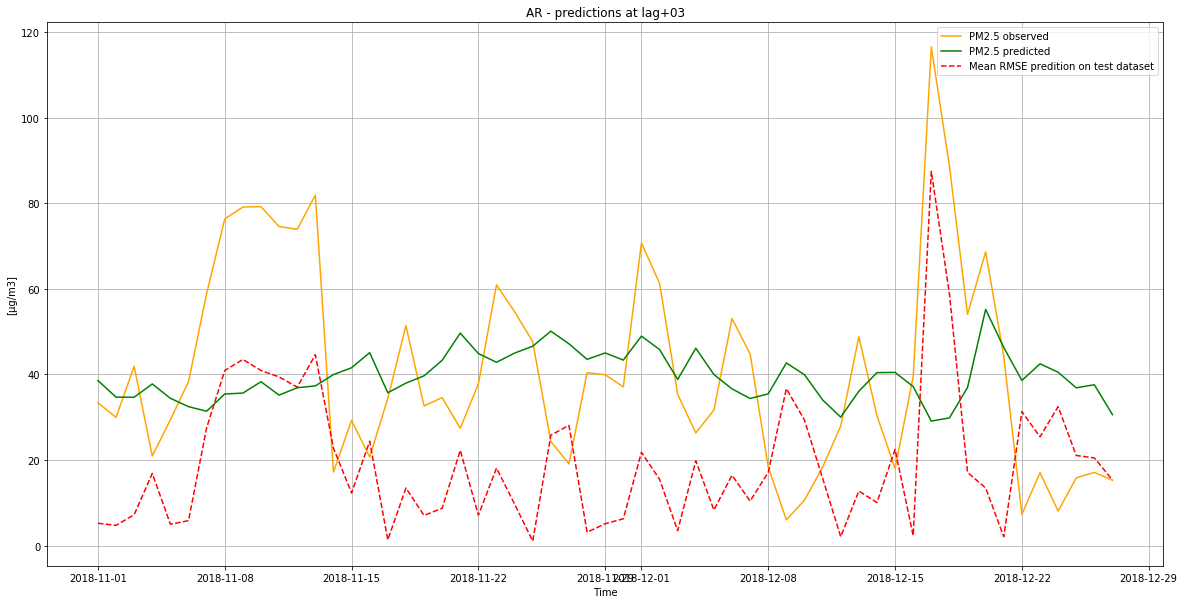

results.py | 83 | visualize_results | 09-Jun-20 00:08:34 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_02_lag-07.png


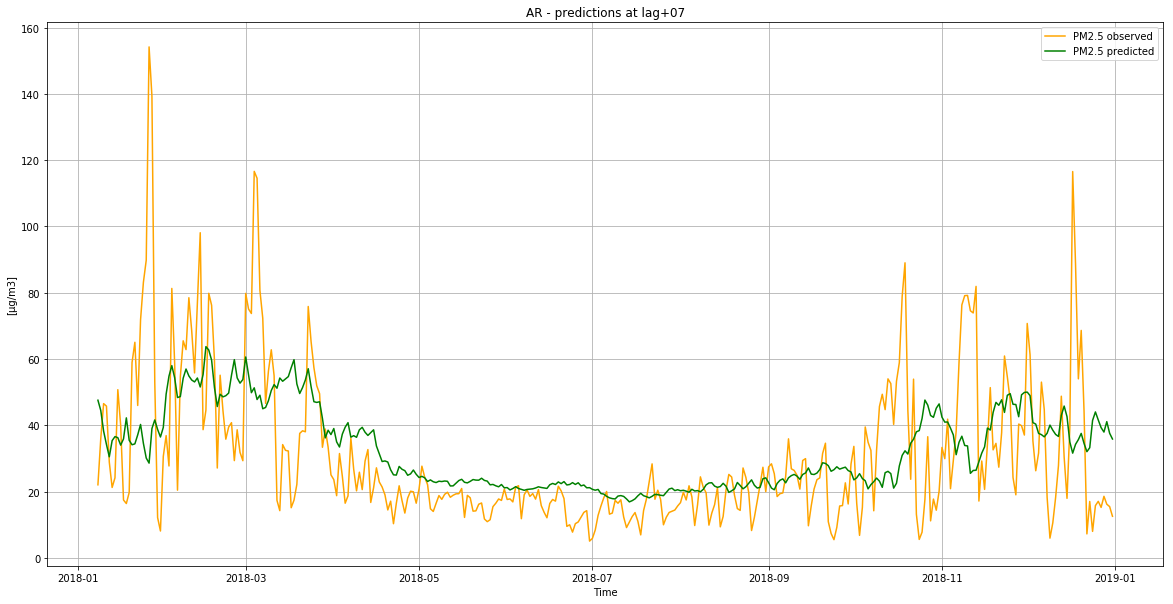

results.py | 83 | visualize_results | 09-Jun-20 00:08:35 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_03_lag-01.png


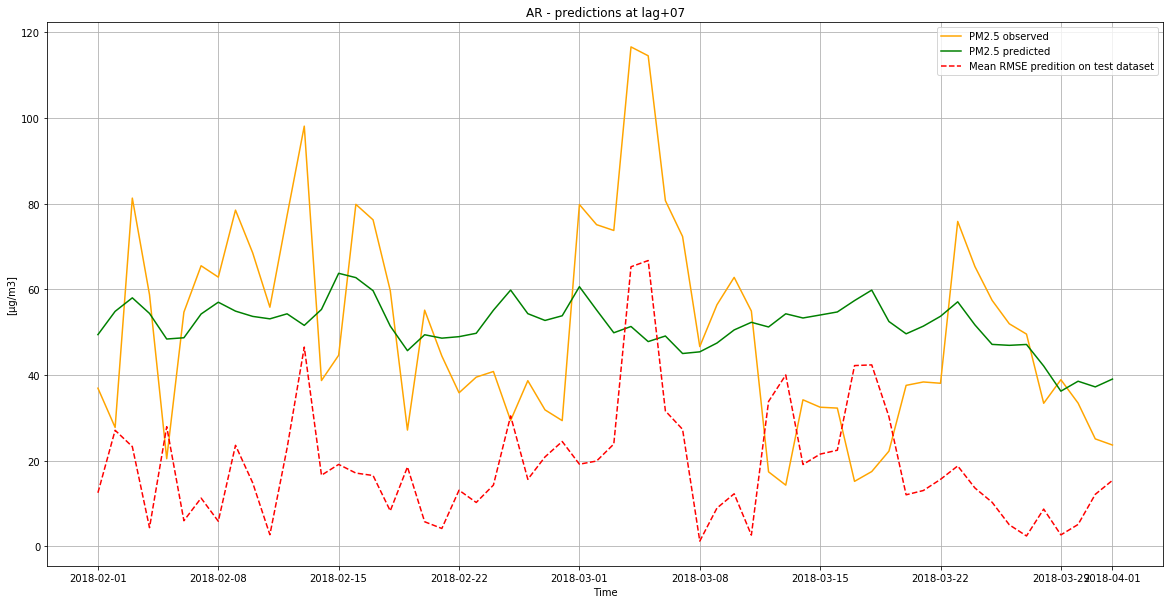

results.py | 83 | visualize_results | 09-Jun-20 00:08:35 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_03_lag-03.png


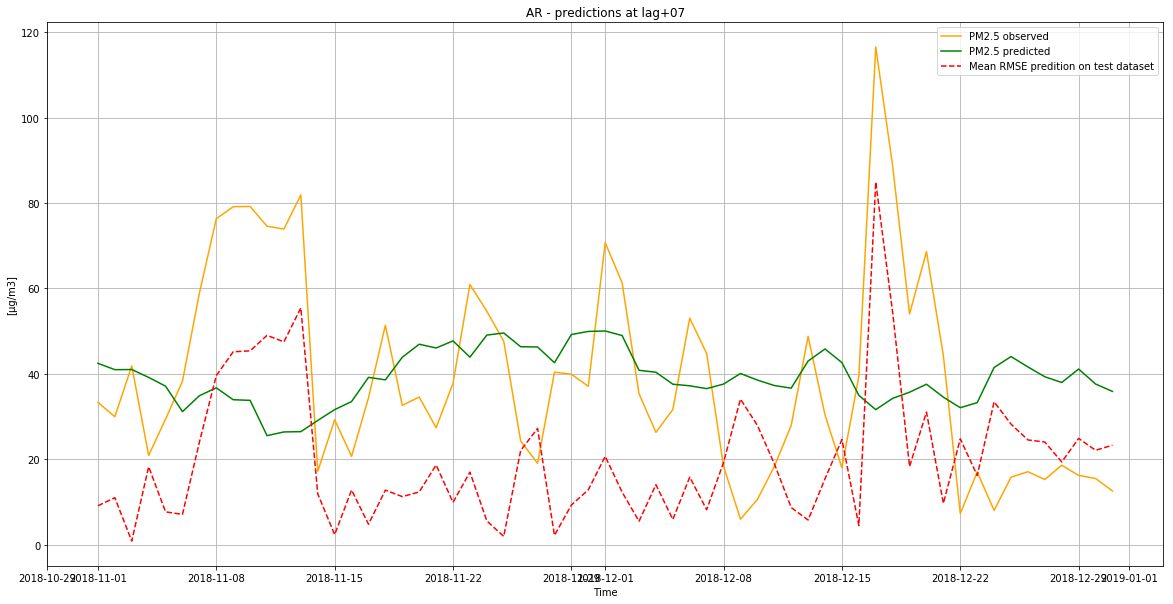

results.py | 83 | visualize_results | 09-Jun-20 00:08:36 | INFO: images/pm25_obs_vs_pred_365_d_ts_AR_03_lag-07.png


In [37]:
visualize_results(show_n_points_of_forecasts=show_n_points_of_forecasts,
                   start_end_dates=start_end_dates,
                   plot_types=plot_types,
                   base_file_path=base_file_path,
                   fold_results=fold_results, 
                   n_pred_points=n_pred_points, 
                   cut_off_offset=cut_off_offset, 
                   model_name=model_name)

In [32]:
# Zooming
start_date = '2018-11'
end_date = '2018-11-30'

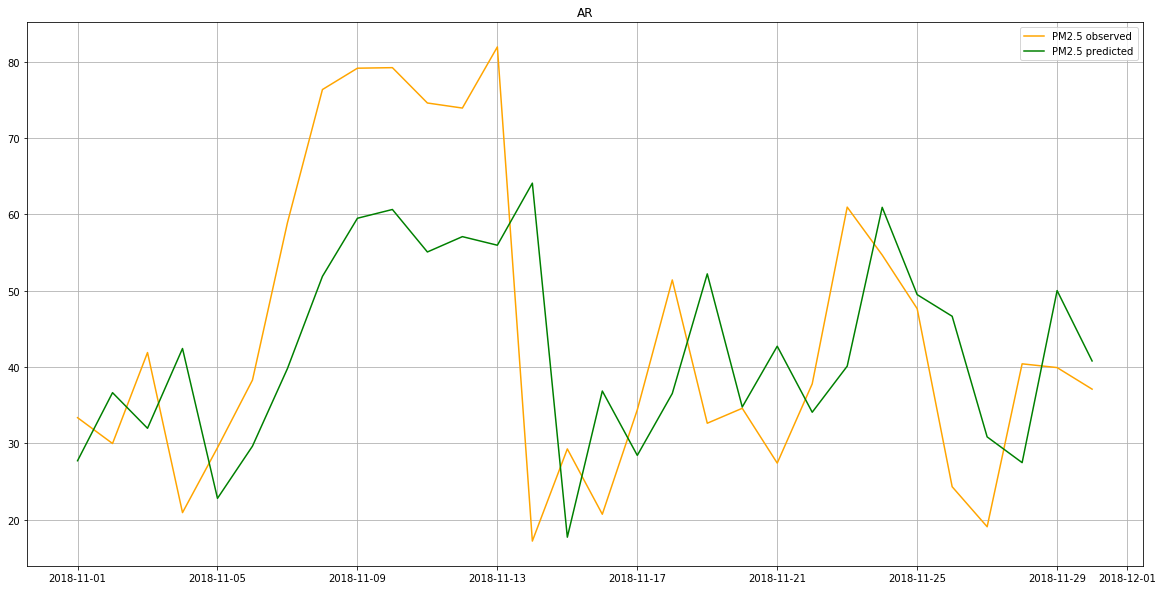

In [33]:
plot_observed_vs_predicted(observed=observed[start_date:end_date],
                           predicted=predicted[start_date:end_date],
                           num_points=cut_off_offset,
                           title=model_name,
                           label_observed='PM2.5 observed',
                           label_predicted='PM2.5 predicted',
                           show_grid = True,
                           save_path='images/pm25_obs_vs_pred_365_h_ref_simple_averageXXXREMOVE.png')

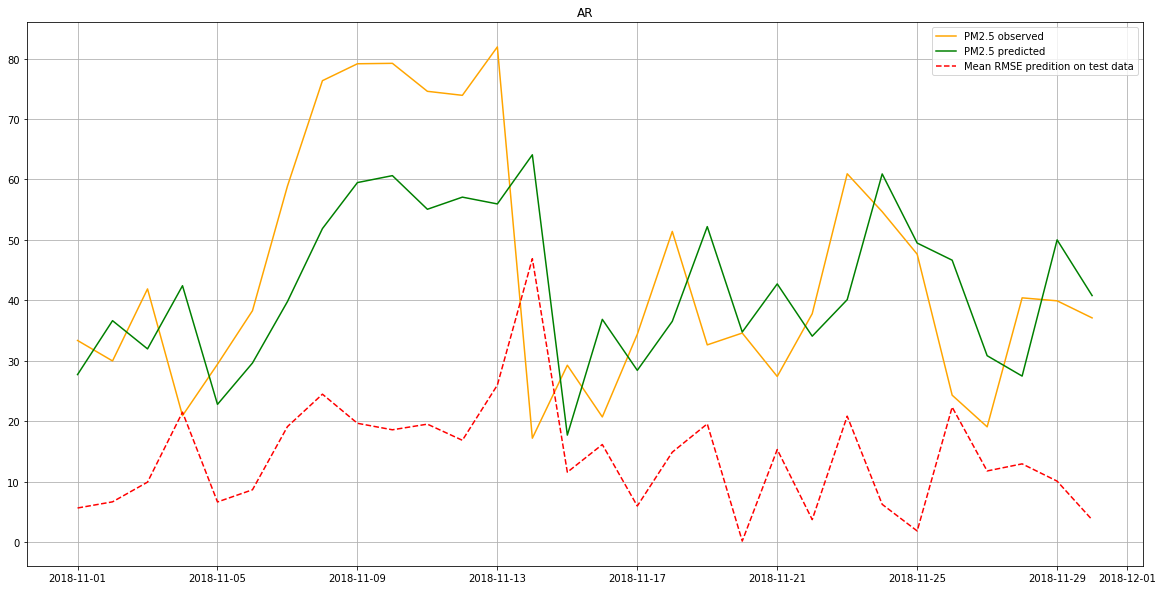

In [34]:
plot_observed_vs_predicted_with_error(observed=observed[start_date:end_date],
                                      predicted=predicted[start_date:end_date],
                                      error=error[start_date:end_date],
                                      num_points=cut_off_offset,
                                      title=model_name,
                                      label_observed='PM2.5 observed',
                                      label_predicted='PM2.5 predicted', 
                                      label_error='Mean RMSE predition on test data',
                                      show_grid = True,
                                      save_path='images/pm25_obs_vs_pred_365_h_ref_simple_averageXXXREMOVE.png')